# Capstone Project - Where to locate a new restaurant in Munich?

## Background

Eating out is a popular pastime in Germany, with almost 51.3 million people sometimes doing so in 2019, and roughly 11.9 million people stating they often did so. Many young people dream about starting their own restaurant, someday.  The size of restaurant industry market is continuously increasing, 

Jack lives at Munich.  He has a strong interest in restaurant industry, and he has undergone a long process of training in Japan to learn how to cook Japanese cuisine. Now, he decided to start his own Japanese restaurant at Munich.  

## Business Problem
Munich is the capital and most populous city of Bavaria, the second most populous German state. With a population of around 1.5 million, it is the third-largest city in Germany.  As a global city, Munich has a lot of restaurants that offer German, English and other continental cuisine.  In these several years, with more and more drastic competition, the location of food service business will impact its success nearly as much as the menu. 

Jack worries a lot about the location of his new restaurant, and he finds a market analysis agency to help him pick a district to start his new business.  

## Data preparation

**Based on definition of the business problem, factors will influence our decision are:**
* population base
* foreigner population ratio 
* venues categories within each district

In order to take all above factors into consideration, the geographic data, population data as well as venues data are required for each Munich district.

Prepare the required packages

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import folium
import random 
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs 

### Munich district data 
Scrape the Munich district information, including district, surface, population, density and foreigners%

In [2]:
URL='http://www.total-munich.com/20160623888/blog/moving-to-munich/moving-to-munich-introduction-to-munich-s-boroughs.html'
page=requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')

In [3]:
tables = soup.find('table') #find the table
rows=tables.find_all('tr')
columns=[v.text.replace('\n','') for v in rows[0].find_all('td')] # find the column names
df=pd.DataFrame(columns=columns)

In [4]:
column_name_td=soup.find('table').find_all('tr')
column_name_td[0].find_all('td')

for i in range(1,len(rows)): 
    tds=rows[i].find_all('td')
    values=[tds[0].text.replace('\n',''),tds[1].text.replace('\n',''),tds[2].text.replace('\n','') \
           ,tds[3].text.replace('\n',''),tds[4].text.replace('\n',''),tds[5].text.replace('\n','')]
    df=df.append(pd.Series(values,index=columns),ignore_index=True)

In [5]:
# Tidy Data
df.drop([25,26],axis=0,inplace=True)
df.drop(['No.'],axis=1,inplace=True)

In [6]:
#Copy the above data into muich_df
Munich_df=df.copy()
print("There are",Munich_df.shape[0], "districs in Munich")

#Create the column to store the latitude and longiture information
Munich_df['latitude']=list([0])*Munich_df.shape[0]
Munich_df['longitude']=list([0])*Munich_df.shape[0]
Munich_df=Munich_df.sort_values(by='District')

There are 25 districs in Munich


In [7]:
Munich_df.reset_index(drop=True,inplace=True)

###  Munich district data with post code
Second, get the post code for each districts in Munich

In [8]:
URL2='https://www.muenchen.de/int/en/living/postal-codes.html'
page2=requests.get(URL2)
soup2 = BeautifulSoup(page2.content, 'html.parser')

In [9]:
tables2 = soup2.find('table') #find the table
rows2=tables2.find_all('tr')
#Store the column names of the table
columns2=list()
for i in range(0,int(len(soup2.find('table').find_all('th')))):
   columns2.append(soup2.find('table').find_all('th')[i].text)

#Generate a new data frame to store post code info
df2=pd.DataFrame(columns=columns2)

Third, get the coordinates of these districts

In [10]:
import re
for i in range(1,len(rows2)):
    df2.loc[i-1,'Postal Code']=re.findall(r"\d+\.?\d*",rows2[i].text)[0] #Get the post code for district
    df2.loc[i-1,'District']=re.sub(u"([^\u0041-\u007a])"," ",rows2[i].text) ##Get the district name

In [11]:
Post_code_list=df2.sort_values(by=['District'])['Postal Code']
Munich_df['Postal_Code']=Post_code_list

### Munich district data with post code and coordinates
Use python to realize the get command to get the coordinates
Here we need to search the coordinates for each district in Munich

In [12]:
import requests
for i in range(0,Munich_df.shape[0]):
    post_data=Munich_df['Postal_Code'][i]
    URL3='https://www.all-zipcodes.com/postcode-munchen-in-germany-'+post_data+'/' #post_data is updated at each row
    r = requests.get(URL3)
    soup3 = BeautifulSoup(r.content, 'html.parser')
    content_list=soup3.find_all("script")[2].text
    Munich_df.loc[i,'latitude']=content_list.split(";")[5].split('setView')[1].split(',')[0].replace(r'([',"")
    Munich_df.loc[i,'longitude']=content_list.split(";")[5].split('setView')[1].split(',')[1].replace(r']',"")
Munich_df.head()   

,District,Surface (km²),Population,Density (Persons/km²),Foreigners (%),latitude,longitude,Postal_Code
0,Allach-Untermenzing,15.45,"31,353","2,029",19.5,48.217157311,11.5149477676,80995
1,Altstadt-Lehel,3.15,"20,806","6,614",25.8,48.1359642378,11.5729048503,80331
2,Au-Haidhausen,4.22,"60,756","14,399",23.4,48.1204341448,11.5874447961,81541
3,Aubing-Lochhausen-Langwied,34.06,"42,859","1,258",23.3,48.1452756567,11.4368110446,81243
4,Berg am Laim,6.31,"44,002","6,971",29.9,48.1219040581,11.6182992419,81671


In [13]:
# Change the datatype into int or float
Density= Munich_df['Density (Persons/km²)']
Surface=Munich_df['Surface (km²)']
Foreigners=Munich_df['Foreigners (%)']
Population=Munich_df['Population']
for i in range(0,len(Density)):
    Density[i]=int(str(Munich_df['Density (Persons/km²)'][i]).replace(',',""))
    Surface[i]=float(str(Munich_df['Surface (km²)'][i]))
    Foreigners[i]=float(str(Munich_df['Foreigners (%)'][i]))
    Population[i]=int(str(Munich_df['Population'][i]).replace(',',""))
Munich_df['Density (Persons/km²)']=Density
Munich_df['Surface (km²)']=Surface
Munich_df['Foreigners (%)']=Foreigners
Munich_df['Population']=Population

In [14]:
Density

0      2029
1      6614
2     14399
3      1258
4      6971
5      3539
6      2082
7      5407
8     10351
9     11855
10    12233
11     5565
12     4747
13     7551
14     9220
15     4357
16     5534
17     2797
18    15378
19    14531
20    10263
21     7228
22     5146
23     3032
24     6510
Name: Density (Persons/km²), dtype: object

### Munich district venue data
Explore all the districts in Munich

**Definie Foursquare Credentials and Version**

In [15]:
CLIENT_ID = 'PATK1E03HKIFW5QPDDKW5JM0XUKV3LI0ILOCNSTPNBKUS5WC' # your Foursquare ID
CLIENT_SECRET = 'W5HKS1OU2KAMPYCYOY13E1SDDMDQHLFYQFGV0CHG25AVBVV5' # your Foursquare Secret
VERSION = '20200605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PATK1E03HKIFW5QPDDKW5JM0XUKV3LI0ILOCNSTPNBKUS5WC
CLIENT_SECRET:W5HKS1OU2KAMPYCYOY13E1SDDMDQHLFYQFGV0CHG25AVBVV5


**Get the top 100 venues that are in  each Munich district within 1000 meters**

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000,limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'latitude', 
                  'longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**Explore top100 venues at all districts in Munich**

In [17]:
Munich_venues = getNearbyVenues(names=Munich_df['District'],
                                   latitudes=Munich_df['latitude'],
                                   longitudes=Munich_df['longitude']
                                  )
# Replace the column names

Allach-Untermenzing
Altstadt-Lehel
Au-Haidhausen
Aubing-Lochhausen-Langwied
Berg am Laim
Bogenhausen
Feldmoching-Hasenbergl
Hadern
Laim
Ludwigsvorstadt-Isarvorstadt
Maxvorstadt
Milbertshofen-Am Hart
Moosach
Neuhausen-Nymphenburg
Obergiesing-Fasangarten
Pasing-Obermenzing
Ramersdorf-Perlach
Schwabing-Freimann
Schwabing-West
Schwanthalerhöhe
Sendling
Sendling-Westpark
Thalkirchen-Obersendling- Forstenried-Fürstenried-Solln
Trudering-Riem
Untergiesing-Harlaching


## Analysis

### Analyze the population data in Munich

In [18]:
# Munich latitude and longitude values
latitude = 48.137154
longitude = 11.576124

In [19]:
Munich_map = folium.Map(location=[latitude,longitude], zoom_start=13)

In [20]:
# instantiate a feature group for the district location in the dataframe
districts = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
i=0
for lat, lng, in zip(Munich_df.latitude.map(float),Munich_df.longitude.map(float)):
    districts.add_child(
        folium.features.Circle(
            [lat, lng],
            popup=str(Munich_df.iloc[i]['District'])+': '+str(Density[i])+" per square kilometer",
            radius=Density[i]/Density.max()*400, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
    i=i+1

# add districts to map
Munich_map.add_child(districts)

In [21]:
#Sort the district based on the population density
Density_sort=Munich_df.loc[:,['District','Density (Persons/km²)']]
Density_sort.sort_values(by='Density (Persons/km²)',inplace=True,ascending=False)
Density_sort.reset_index(drop=True,inplace=True)

#Fihd out the districts whoes density is above the average
Density_District_candidate=Density_sort[Density_sort['Density (Persons/km²)']>=Density_sort['Density (Persons/km²)'].mean()]['District']
Density_District_candidate

0                  Schwabing-West
1                Schwanthalerhöhe
2                   Au-Haidhausen
3                     Maxvorstadt
4    Ludwigsvorstadt-Isarvorstadt
5                            Laim
6                        Sendling
7         Obergiesing-Fasangarten
8           Neuhausen-Nymphenburg
9               Sendling-Westpark
Name: District, dtype: object

Since each restaurant has a limited radius of service, instead of the toal population at each district, we pay more attention to the population density (Persons/km²). We select out all districts whoes density is above the average density level in munich. Because high population density means that the resteraunt can cover more potential customers within its radius of service.

We store these districts into dataframe **'Density_District_candidate'**.

In [22]:
Munich_df.head()

,District,Surface (km²),Population,Density (Persons/km²),Foreigners (%),latitude,longitude,Postal_Code
0,Allach-Untermenzing,15.45,31353,2029,19.5,48.217157311,11.5149477676,80995
1,Altstadt-Lehel,3.15,20806,6614,25.8,48.1359642378,11.5729048503,80331
2,Au-Haidhausen,4.22,60756,14399,23.4,48.1204341448,11.5874447961,81541
3,Aubing-Lochhausen-Langwied,34.06,42859,1258,23.3,48.1452756567,11.4368110446,81243
4,Berg am Laim,6.31,44002,6971,29.9,48.1219040581,11.6182992419,81671


### Analyze the foreigners ratio
Since Japanese food is an international food for Munich people. Thus, we assume that the higher ratio of foreigner is, the better location that district is. 
So, we start to analyze the foreigner ratio data and store the candidate district in term of foreigner ratio into dataframe **'Foreigners_District_candidate'**

In [23]:
Foreigners_sort=Munich_df.loc[:,['District','Foreigners (%)']]
Foreigners_sort.sort_values(by='Foreigners (%)',inplace=True,ascending=False)
Foreigners_sort.reset_index(drop=True,inplace=True)

#Find out the districts whose Foreigners is above the average
Foreigners_District_candidate=Foreigners_sort[Foreigners_sort['Foreigners (%)']>=Foreigners_sort['Foreigners (%)'].mean()]['District']
Foreigners_District_candidate

0            Milbertshofen-Am Hart
1                 Schwanthalerhöhe
2               Ramersdorf-Perlach
3           Feldmoching-Hasenbergl
4     Ludwigsvorstadt-Isarvorstadt
5          Obergiesing-Fasangarten
6                     Berg am Laim
7                          Moosach
8               Schwabing-Freimann
9                Sendling-Westpark
10                        Sendling
Name: District, dtype: object

### Analyze the Restaurant Industry in Munich

Get an overview of munich venues data at each district

In [24]:
Munich_venues.head()
print("There are ",len(Munich_venues['Venue Category'].unique())," categories of venues of each district in Munich.")

There are  219  categories of venues of each district in Munich.


#### The restaurant industry in Munich

In [25]:
# Sort the venue data based on the count of each category
columnname=['Venue Category','Count']
Munich_venues_categories_df=pd.DataFrame(Munich_venues.groupby('Venue Category',as_index=False)['Venue'].count())
Munich_venues_categories_df.columns=columnname
Munich_venues_categories_df.sort_values(by='Count',inplace=True,ascending=False)
Munich_venues_categories_df.reset_index(drop=True,inplace=True)

In [26]:
# Find all Venue Category contains the string "Restaurant"
Munich_Restaurant_df=Munich_venues_categories_df[Munich_venues_categories_df['Venue Category'].str.contains("Restaurant")]
Munich_Restaurant_df.reset_index(drop=True,inplace=True)
Munich_Restaurant_df
print('There exists',Munich_Restaurant_df.loc[8,'Count'], "Japanese retaurant in Munich","and the ranking is 9.")


There exists 15 Japanese retaurant in Munich and the ranking is 9.


Text(7, 30, 'Japanese Restaurant')

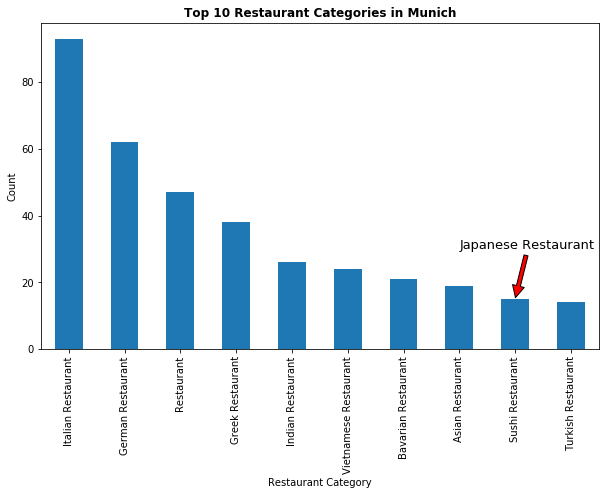

In [27]:
#Use the bar chart to visualize the top 10 reastaurant category in Munich
%matplotlib inline

Munich_Restaurant_Top10_category=Munich_Restaurant_df.head(10)
Munich_Restaurant_Top10_category.set_index('Venue Category',inplace=True)

bar_plot=Munich_Restaurant_Top10_category.plot(kind='bar', figsize=(10, 6),
                                     legend=False)
plt.xlabel('Restaurant Category') # add to x-label to the plot
plt.ylabel('Count') # add y-label to the plot
plt.title('Top 10 Restaurant Categories in Munich',size=12,fontweight="bold") # add title to the plot

bar_plot.annotate('Japanese Restaurant', xy=(8, 15), xytext=(7,30),
            xycoords='data',size=13,
            arrowprops=dict(facecolor='red', shrink=0.03)
            )

**From above bar chart**, we find that the Japanese restaurant (Sushi Restaurant) ranks at 9th at all restaurants in Munich. From market sharing perspective, there is still a huge growth potential for Japanese restaurant. But on the other hand, there exits 15 Japanese restaurant. Thus, Jack's new restaurant should keep a distance with existing Japanese retaurant.

#### The Japanese restaurant in Munich

In [28]:
Munich_Japanese_Restaurant_df=Munich_venues[Munich_venues['Venue Category'].str.contains("Sushi Restaurant")]
Munich_Japanese_Restaurant_df

,District,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
347,Bogenhausen,48.1391052689,11.6027305035,Nomiya,48.131653,11.598526,Sushi Restaurant
359,Bogenhausen,48.1391052689,11.6027305035,Sushi Bento,48.139390,11.592329,Sushi Restaurant
434,Laim,48.1321268962,11.5122375474,Umeshu Sushibar,48.137233,11.523225,Sushi Restaurant
467,Laim,48.1321268962,11.5122375474,Ozeansushi,48.128715,11.501577,Sushi Restaurant
497,Ludwigsvorstadt-Isarvorstadt,48.1455583623,11.5539521328,Kaito,48.149599,11.560872,Sushi Restaurant
624,Maxvorstadt,48.1451898327,11.5687437028,Kaito,48.149599,11.560872,Sushi Restaurant
755,Moosach,48.1631648746,11.5371388473,Yee Chino,48.163014,11.542663,Sushi Restaurant
845,Neuhausen-Nymphenburg,48.1492412073,11.5296343596,Hanami Sushi Addict,48.154086,11.530399,Sushi Restaurant
847,Neuhausen-Nymphenburg,48.1492412073,11.5296343596,Sushi Sado,48.146706,11.533601,Sushi Restaurant
903,Neuhausen-Nymphenburg,48.1492412073,11.5296343596,FUJI Sushi & Nudel,48.152012,11.535807,Sushi Restaurant


**Use map to explore where are these Japanese restaurant located**

In [29]:
Munich_Japanese_Restaurant_map = folium.Map(location=[latitude,longitude], zoom_start=12)

In [30]:
# instantiate a feature group for the district location in the dataframe
Japanese_Restaurant = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
i=0
for lat, lng, in zip(Munich_Japanese_Restaurant_df.latitude.map(float),Munich_Japanese_Restaurant_df.longitude.map(float)):
    Japanese_Restaurant.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
    i=i+1

# add districts to map
Munich_Japanese_Restaurant_map.add_child(Japanese_Restaurant)

From above map, we find that the majority of Japanese restaurant are located at the northwest side of munich. We are curious why these Japanese restaurants are closely located with that region.

In order to figure out the reason behind, we use clustering method to group these Japanese restaurant with other venues. 

**We want to use the clustering method to find out what is regular pattern to locate a Japanese restaurant.**

**First, we filter out districts that have at least one Japanese restaurant**

In [31]:
District_Japanese_Restaurant_Exist=(Munich_Japanese_Restaurant_df['District'].unique())
District_Japanese_Restaurant_Exist
Munich_venues_within_District_Japanese_Restaurant_Exist=Munich_venues[Munich_venues['District'].isin(District_Japanese_Restaurant_Exist)]
Munich_venues_within_District_Japanese_Restaurant_Exist.reset_index(inplace=True)
Munich_venues_within_District_Japanese_Restaurant_Exist.head()

,index,District,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,282,Bogenhausen,48.1391052689,11.6027305035,Feinkost Käfer,48.140461,11.602158,Gourmet Shop
1,283,Bogenhausen,48.1391052689,11.6027305035,Käfer Schänke,48.140515,11.601585,Restaurant
2,284,Bogenhausen,48.1391052689,11.6027305035,Prinzregententheater,48.139250,11.605680,Concert Hall
3,285,Bogenhausen,48.1391052689,11.6027305035,Kerala,48.141736,11.602917,Indian Restaurant
4,286,Bogenhausen,48.1391052689,11.6027305035,Prinzregentenbad,48.139436,11.603356,Pool


**Second, generate the venues data of districts with Japanese restaurant and filter out top 10 most frequent venues within these districts**

In [32]:
Munich_venues_within_District_Japanese_Restaurant_Exist.head()

,index,District,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,282,Bogenhausen,48.1391052689,11.6027305035,Feinkost Käfer,48.140461,11.602158,Gourmet Shop
1,283,Bogenhausen,48.1391052689,11.6027305035,Käfer Schänke,48.140515,11.601585,Restaurant
2,284,Bogenhausen,48.1391052689,11.6027305035,Prinzregententheater,48.139250,11.605680,Concert Hall
3,285,Bogenhausen,48.1391052689,11.6027305035,Kerala,48.141736,11.602917,Indian Restaurant
4,286,Bogenhausen,48.1391052689,11.6027305035,Prinzregentenbad,48.139436,11.603356,Pool


In [33]:
# one hot encoding 
Munich_venues_onehot_Japan = pd.get_dummies(Munich_venues_within_District_Japanese_Restaurant_Exist[['Venue Category']], prefix="", prefix_sep="")

# add District column back to dataframe
Munich_venues_onehot_Japan['District'] = Munich_venues_within_District_Japanese_Restaurant_Exist['District'] 

# move neighborhood column to the first column
fixed_columns = [Munich_venues_onehot_Japan.columns[-1]] + list(Munich_venues_onehot_Japan.columns[:-1])
Munich_venues_onehot_Japan =Munich_venues_onehot_Japan[fixed_columns]


Group rows by district and by taking mean of the frequency of occurence of each category

In [34]:
Munich_Japan_Restaurant_grouped = Munich_venues_onehot_Japan.groupby('District').mean().reset_index()
Munich_Japan_Restaurant_grouped

,District,Afghan Restaurant,Art Gallery,Art Museum,Arts & Entertainment,Asian Restaurant,Austrian Restaurant,BBQ Joint,Bakery,Bank,...,Tram Station,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio
0,Bogenhausen,0.00,0.01,0.01,0.000000,0.010000,0.000000,0.00,0.040000,0.010000,...,0.000000,0.010000,0.000000,0.010000,0.01,0.020000,0.00,0.000000,0.00,0.000000
1,Laim,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.018868,0.056604,...,0.037736,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000
2,Ludwigsvorstadt-Isarvorstadt,0.01,0.00,0.01,0.000000,0.020000,0.000000,0.00,0.020000,0.000000,...,0.000000,0.020000,0.000000,0.000000,0.00,0.030000,0.01,0.000000,0.00,0.010000
3,Maxvorstadt,0.01,0.00,0.05,0.000000,0.000000,0.000000,0.00,0.010000,0.000000,...,0.000000,0.010000,0.000000,0.000000,0.01,0.010000,0.00,0.000000,0.00,0.000000
4,Moosach,0.00,0.00,0.00,0.011765,0.000000,0.011765,0.00,0.058824,0.000000,...,0.035294,0.047059,0.011765,0.011765,0.00,0.011765,0.00,0.011765,0.00,0.000000
5,Neuhausen-Nymphenburg,0.00,0.00,0.00,0.000000,0.021053,0.010526,0.00,0.042105,0.000000,...,0.010526,0.021053,0.000000,0.010526,0.00,0.031579,0.00,0.010526,0.00,0.010526
6,Schwabing-West,0.01,0.00,0.00,0.000000,0.020000,0.020000,0.00,0.020000,0.000000,...,0.000000,0.040000,0.000000,0.000000,0.00,0.050000,0.00,0.000000,0.00,0.000000
7,Schwanthalerhöhe,0.01,0.00,0.01,0.000000,0.020000,0.000000,0.00,0.020000,0.000000,...,0.000000,0.020000,0.000000,0.000000,0.00,0.030000,0.01,0.000000,0.00,0.010000
8,Sendling,0.00,0.01,0.00,0.000000,0.030000,0.000000,0.01,0.010000,0.000000,...,0.000000,0.010000,0.000000,0.010000,0.01,0.040000,0.02,0.010000,0.01,0.000000
9,Sendling-Westpark,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.018868,0.056604,...,0.037736,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000


Print each neigborhood with top 10 most common venues

num_top_venues = 10

for dist in Munich_Japan_Restaurant_grouped['District']:
    print("----"+dist+"----")
    temp =Munich_Japan_Restaurant_grouped[Munich_Japan_Restaurant_grouped['District'] == dist].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

Put the Top 10 venues data into a pandas dataframe

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
district_venues_sorted_Japan = pd.DataFrame(columns=columns)
district_venues_sorted_Japan['District'] = Munich_Japan_Restaurant_grouped['District']

for ind in np.arange(Munich_Japan_Restaurant_grouped.shape[0]):
    district_venues_sorted_Japan.iloc[ind, 1:] = return_most_common_venues(Munich_Japan_Restaurant_grouped.iloc[ind, :], num_top_venues)


**Third, cluster districts with Japanese restaurant**

In [38]:
# set number of clusters
kclusters =3

Munich_Japan_Restaurant_grouped_clustering = Munich_Japan_Restaurant_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Munich_Japan_Restaurant_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 1, 1, 0, 0, 0, 1, 1, 2])

In [39]:
Munich_Japan_Restaurant_grouped_with_cluster=Munich_Japan_Restaurant_grouped.copy()
Munich_Japan_Restaurant_grouped_with_cluster['Cluster']=kmeans.labels_[0:10]
district_venues_sorted_Japan['Cluster']=kmeans.labels_[0:10]
district_venues_sorted_Japan.sort_values(by='Cluster',inplace=True)

Cluster 1 for Japanese Restaurant and District venues

In [40]:
district_venues_sorted_Japan[district_venues_sorted_Japan['Cluster']==0]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster
0,Bogenhausen,Italian Restaurant,Hotel,Café,Plaza,Bar,Bakery,Restaurant,German Restaurant,Ice Cream Shop,Indian Restaurant,0
4,Moosach,Italian Restaurant,German Restaurant,Bakery,Trattoria/Osteria,Plaza,Tram Station,Café,Gastropub,Indian Restaurant,Restaurant,0
5,Neuhausen-Nymphenburg,Italian Restaurant,German Restaurant,Indian Restaurant,Bakery,Café,Sushi Restaurant,Vietnamese Restaurant,Hotel,Plaza,Asian Restaurant,0
6,Schwabing-West,Italian Restaurant,Café,Vietnamese Restaurant,Bar,Trattoria/Osteria,Gastropub,Greek Restaurant,Pizza Place,Plaza,Thai Restaurant,0


Cluster 2 for Japanese Restaurant and District venues

In [41]:
district_venues_sorted_Japan[district_venues_sorted_Japan['Cluster']==1]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster
2,Ludwigsvorstadt-Isarvorstadt,Hotel,Café,Italian Restaurant,Restaurant,Middle Eastern Restaurant,German Restaurant,Steakhouse,Vietnamese Restaurant,Burger Joint,Trattoria/Osteria,1
3,Maxvorstadt,Café,Plaza,Restaurant,Art Museum,Ice Cream Shop,Hotel,Boutique,German Restaurant,Steakhouse,Italian Restaurant,1
7,Schwanthalerhöhe,Hotel,Café,Italian Restaurant,Restaurant,Middle Eastern Restaurant,German Restaurant,Steakhouse,Vietnamese Restaurant,Burger Joint,Trattoria/Osteria,1
8,Sendling,Hotel,Café,German Restaurant,Bavarian Restaurant,Vietnamese Restaurant,Italian Restaurant,Asian Restaurant,Middle Eastern Restaurant,Burger Joint,Plaza,1


Cluster 3 for Japanese Restaurant and District venues

In [42]:
district_venues_sorted_Japan[district_venues_sorted_Japan['Cluster']==2]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster
1,Laim,Bus Stop,Supermarket,Hotel,Bank,Tram Station,Light Rail Station,Sushi Restaurant,Restaurant,Mobile Phone Shop,Pizza Place,2
9,Sendling-Westpark,Bus Stop,Supermarket,Hotel,Bank,Tram Station,Light Rail Station,Sushi Restaurant,Restaurant,Mobile Phone Shop,Pizza Place,2


**Analyze of clustering result**
Mainly, there are three groups of Japanese Restaurats prefered location:
1. The location closes to other restaurants like Italian restaurant, german restaurant.
2. The location closes to Hotel and cafe.
3. The location closes to Bus Stop, Supermareket,bank and train station.

### Find the similar district without a Japanese Restaurant
At above section, we analyze the venues data to find the pattern where the existing Japanese restaurants are located. In order to reduce the horizontal competion, we would like to find a similar district in term of venues and population charateristic without any Japanese restaurants for Jack's new restaunratn.

**First, wrangle the venue data for clustering. Compared with 1.4.3.2, in this part, we take all districts into consideration**

In [43]:
# one hot encoding 
Munich_venues_onehot = pd.get_dummies(Munich_venues['Venue Category'], prefix="", prefix_sep="")

# add District column back to dataframe
Munich_venues_onehot['District'] = Munich_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [Munich_venues_onehot.columns[-1]] + list(Munich_venues_onehot.columns[:-1])
Munich_venues_onehot =Munich_venues_onehot[fixed_columns]

In [44]:
Munich_venues_onehot
Munich_District_grouped = Munich_venues_onehot.groupby('District').mean().reset_index()
Munich_District_grouped.head()

,District,Afghan Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Austrian Restaurant,...,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfall,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio
0,Allach-Untermenzing,0.0,0.0,0.00,0.00,0.00,0.0,0.000000,0.0,0.00,...,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.00,0.0,0.00
1,Altstadt-Lehel,0.0,0.0,0.01,0.00,0.01,0.0,0.000000,0.0,0.00,...,0.000000,0.000000,0.000000,0.01,0.010000,0.0,0.01,0.01,0.0,0.01
2,Au-Haidhausen,0.0,0.0,0.00,0.00,0.00,0.0,0.010309,0.0,0.00,...,0.020619,0.000000,0.041237,0.00,0.010309,0.0,0.00,0.00,0.0,0.00
3,Aubing-Lochhausen-Langwied,0.0,0.0,0.00,0.00,0.00,0.0,0.068966,0.0,0.00,...,0.000000,0.034483,0.000000,0.00,0.000000,0.0,0.00,0.00,0.0,0.00
4,Berg am Laim,0.0,0.0,0.00,0.02,0.00,0.0,0.060000,0.0,0.02,...,0.000000,0.000000,0.020000,0.00,0.000000,0.0,0.00,0.00,0.0,0.00


**Second, find the Top 10 venues data for all districts**

In [45]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = Munich_District_grouped['District']

for ind in np.arange(Munich_District_grouped.shape[0]):
    district_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Munich_District_grouped.iloc[ind, :], num_top_venues)
district_venues_sorted.head()


,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allach-Untermenzing,Motorcycle Shop,Bus Stop,BBQ Joint,Lake,Beer Garden,Greek Restaurant,Yoga Studio,Event Space,Food Court,Food & Drink Shop
1,Altstadt-Lehel,Café,German Restaurant,Plaza,Hotel,Bavarian Restaurant,Coffee Shop,Department Store,Clothing Store,Boutique,Gourmet Shop
2,Au-Haidhausen,Italian Restaurant,Café,Plaza,Greek Restaurant,Bar,Pizza Place,Supermarket,Hotel,Turkish Restaurant,Restaurant
3,Aubing-Lochhausen-Langwied,Supermarket,Italian Restaurant,Bowling Alley,Asian Restaurant,Drugstore,Automotive Shop,Fruit & Vegetable Store,Light Rail Station,Big Box Store,Lake
4,Berg am Laim,Nightclub,Supermarket,Asian Restaurant,Climbing Gym,German Restaurant,Bus Stop,Restaurant,Italian Restaurant,Gas Station,Fried Chicken Joint


**Third,take population related data into the Munich_District_grouped dataframe.**

Besides the venues data, we need to take the population data into the consideration, like the population density as well as 

In [46]:
Munich_District_grouped_population=Munich_District_grouped.copy()
Munich_District_grouped_population=pd.merge(Munich_df[['District','Density (Persons/km²)','Foreigners (%)']],Munich_District_grouped_population, on='District')
Munich_District_grouped_population.head()

,District,Density (Persons/km²),Foreigners (%),Afghan Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Entertainment,Asian Restaurant,...,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfall,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio
0,Allach-Untermenzing,2029,19.5,0.0,0.0,0.00,0.00,0.00,0.0,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.00,0.0,0.00
1,Altstadt-Lehel,6614,25.8,0.0,0.0,0.01,0.00,0.01,0.0,0.000000,...,0.000000,0.000000,0.000000,0.01,0.010000,0.0,0.01,0.01,0.0,0.01
2,Au-Haidhausen,14399,23.4,0.0,0.0,0.00,0.00,0.00,0.0,0.010309,...,0.020619,0.000000,0.041237,0.00,0.010309,0.0,0.00,0.00,0.0,0.00
3,Aubing-Lochhausen-Langwied,1258,23.3,0.0,0.0,0.00,0.00,0.00,0.0,0.068966,...,0.000000,0.034483,0.000000,0.00,0.000000,0.0,0.00,0.00,0.0,0.00
4,Berg am Laim,6971,29.9,0.0,0.0,0.00,0.02,0.00,0.0,0.060000,...,0.000000,0.000000,0.020000,0.00,0.000000,0.0,0.00,0.00,0.0,0.00


In order to get better clustering result, we should scalar the "Density (Persons/km²)" and "Foreigners (%)"

In [47]:
Munich_District_grouped_population['Density (Persons/km²)']=Munich_District_grouped_population['Density (Persons/km²)']/Munich_District_grouped_population['Density (Persons/km²)'].max()
Munich_District_grouped_population['Foreigners (%)']=Munich_District_grouped_population['Foreigners (%)']/Munich_District_grouped_population['Foreigners (%)'].max()

**Cluster these districts**

In [48]:
# set number of clusters
kclusters =3

Munich_District_grouped_clustering = Munich_District_grouped_population.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Munich_District_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 0, 2, 1, 2, 2, 2, 0, 0])

Generate the cluster result table

In [49]:
columns=['District','Cluster','Japan_Rest','Density (Persons/km²)','Foreigners (%)']
Munich_District_Cluster_Result=pd.DataFrame(columns=columns)
Munich_District_Cluster_Result['District']=Munich_District_grouped_population['District']
Munich_District_Cluster_Result['Cluster']=kmeans.labels_
Munich_District_Cluster_Result['Density (Persons/km²)']=Munich_District_grouped_population['Density (Persons/km²)']
Munich_District_Cluster_Result['Foreigners (%)']=Munich_District_grouped_population['Foreigners (%)']

#Fill in the boolean variable Japan_Rest 
Munich_District_Cluster_Result['Japan_Rest']=Munich_District_Cluster_Result['District'].isin(District_Japanese_Restaurant_Exist)
Munich_District_Cluster_Result.head()

,District,Cluster,Japan_Rest,Density (Persons/km²),Foreigners (%)
0,Allach-Untermenzing,2,False,0.131942,0.497449
1,Altstadt-Lehel,1,False,0.430095,0.658163
2,Au-Haidhausen,0,False,0.936338,0.596939
3,Aubing-Lochhausen-Langwied,2,False,0.0818052,0.594388
4,Berg am Laim,1,False,0.45331,0.762755


Sort the result table by its cluster

In [50]:
Munich_District_Cluster_Result.sort_values(by='Cluster',inplace=True)
Munich_District_Cluster_Result.reset_index(inplace=True)
Munich_District_Cluster_Result

,index,District,Cluster,Japan_Rest,Density (Persons/km²),Foreigners (%)
0,2,Au-Haidhausen,0,False,0.936338,0.596939
1,20,Sendling,0,True,0.667382,0.681122
2,19,Schwanthalerhöhe,0,True,0.944921,0.867347
3,18,Schwabing-West,0,True,1,0.568878
4,8,Laim,0,True,0.673104,0.655612
5,9,Ludwigsvorstadt-Isarvorstadt,0,True,0.770906,0.770408
6,10,Maxvorstadt,0,True,0.795487,0.663265
7,12,Moosach,1,True,0.308688,0.755102
8,21,Sendling-Westpark,1,True,0.470022,0.693878
9,16,Ramersdorf-Perlach,1,False,0.359865,0.803571


### Find the ideal district to locate Jack's restaurant

At the business problem part, we mentioned that there are three main factors that impacts the location selection, respectively, population base,foreigner population ratio and venues categories within each district. In this part, we will take all above factors into consideration to find the ideal district to locate Jack's restaurant. 

Following dataframe will be used:
1. **Density_District_candidate**: candidate districts based on the population related data
2. **Foreigners_District_candidate**: candidate districts based on the foreigner ratio data
3. **district_venues_sorted**: Top 10 Venues in each district
4. **Munich_District_Cluster_Result**: The clustering result of districts based on venues data
5. **District_Japanese_Restaurant_Exist**: The district that has at least one Japanese restaurant


**First, we use the intersection set to find out the district that doesn't have a Japanese Restaurant, simultaneously, that district has high population density and high foreigner ratio.**

In [51]:
Ideal_District=set(Density_District_candidate)&set(Foreigners_District_candidate)&(set(Munich_District_Cluster_Result['District']).difference(District_Japanese_Restaurant_Exist))
Ideal_District=Ideal_District.pop()
print("The ideal district to open Jack's restaurant is ",Ideal_District)

The ideal district to open Jack's restaurant is  Obergiesing-Fasangarten


**Second, we check the venues within this district and compared this district with the similar districts(at least one Japanese restaurant exists in) to evaluate whether this district is correct.**

In [52]:
Similar_District_df=Munich_District_Cluster_Result[Munich_District_Cluster_Result['Cluster']==int(Munich_District_Cluster_Result[Munich_District_Cluster_Result['District']==Ideal_District].Cluster)]
Similar_District_list=Similar_District_df[Similar_District_df['District'].isin(['Moosach','Sendling-Westpark','Neuhausen-Nymphenburg','Obergiesing-Fasangarten'])].District
district_venues_sorted[district_venues_sorted['District'].isin(Similar_District_list)]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Moosach,German Restaurant,Italian Restaurant,Bakery,Trattoria/Osteria,Café,Plaza,Gastropub,Tram Station,Restaurant,Concert Hall
13,Neuhausen-Nymphenburg,German Restaurant,Italian Restaurant,Indian Restaurant,Bakery,Café,Plaza,Vietnamese Restaurant,Hotel,Sushi Restaurant,Ice Cream Shop
14,Obergiesing-Fasangarten,Supermarket,Hotel,Greek Restaurant,Café,Italian Restaurant,Ice Cream Shop,Plaza,Bakery,Bar,Park
21,Sendling-Westpark,Bus Stop,Supermarket,Hotel,Bank,Tram Station,Sushi Restaurant,Restaurant,Light Rail Station,Pastry Shop,Pizza Place


Compared with other similar area, the  Obergiesing-Fasangarten has less restaurant revenues, which means that the horizontal competition will be acceptable. Besides, Obergiesing-Fasangarten has a lot supermarket, hotel and cafe, thus the pass-by customer is belived to be high. 

**Conclusion**

Based on the analysis, by taking all crucial factors impact the location selection into consideration, we recommend Jack to open his new restaraunt at Obergiesing-Fasangarten	district. Here, the population density is high and the ratio of foreigners is higher than majority districts. Besides, the venues within this district will bring a large number of potential customers paserby. The high exporsure to customers commits a good business. 